In [9]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
%matplotlib inline

In [2]:
start_token = "."
end_token = "."
words = open("./data/hnames.csv", "r").read().splitlines()

In [3]:
chars = list(set(start_token + end_token)) + sorted(list(set("".join(words))))
char_to_idx = {char: index for index, char in enumerate(chars)}
idx_to_char = {index: char for index, char in enumerate(chars)}

len(chars)

29

In [4]:
N = torch.zeros((len(chars), len(chars)), dtype=torch.int32)
N.shape

torch.Size([29, 29])

## Counts Array

In [5]:
bigram_counts = {}
for word in words:
    word_w_tokens = [start_token] + list(word) + [end_token]
    for c1, c2 in zip(word_w_tokens, word_w_tokens[1:]):
        N[char_to_idx.get(c1), char_to_idx.get(c2)] += 1

In [6]:
# N = N + 1 # smoothing
P = (N+1) / (N+1).sum(dim=1, keepdim=True)
P.sum(dim=1) # check to see if broadcasting done properly

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000])

(-0.5, 28.5, 28.5, -0.5)

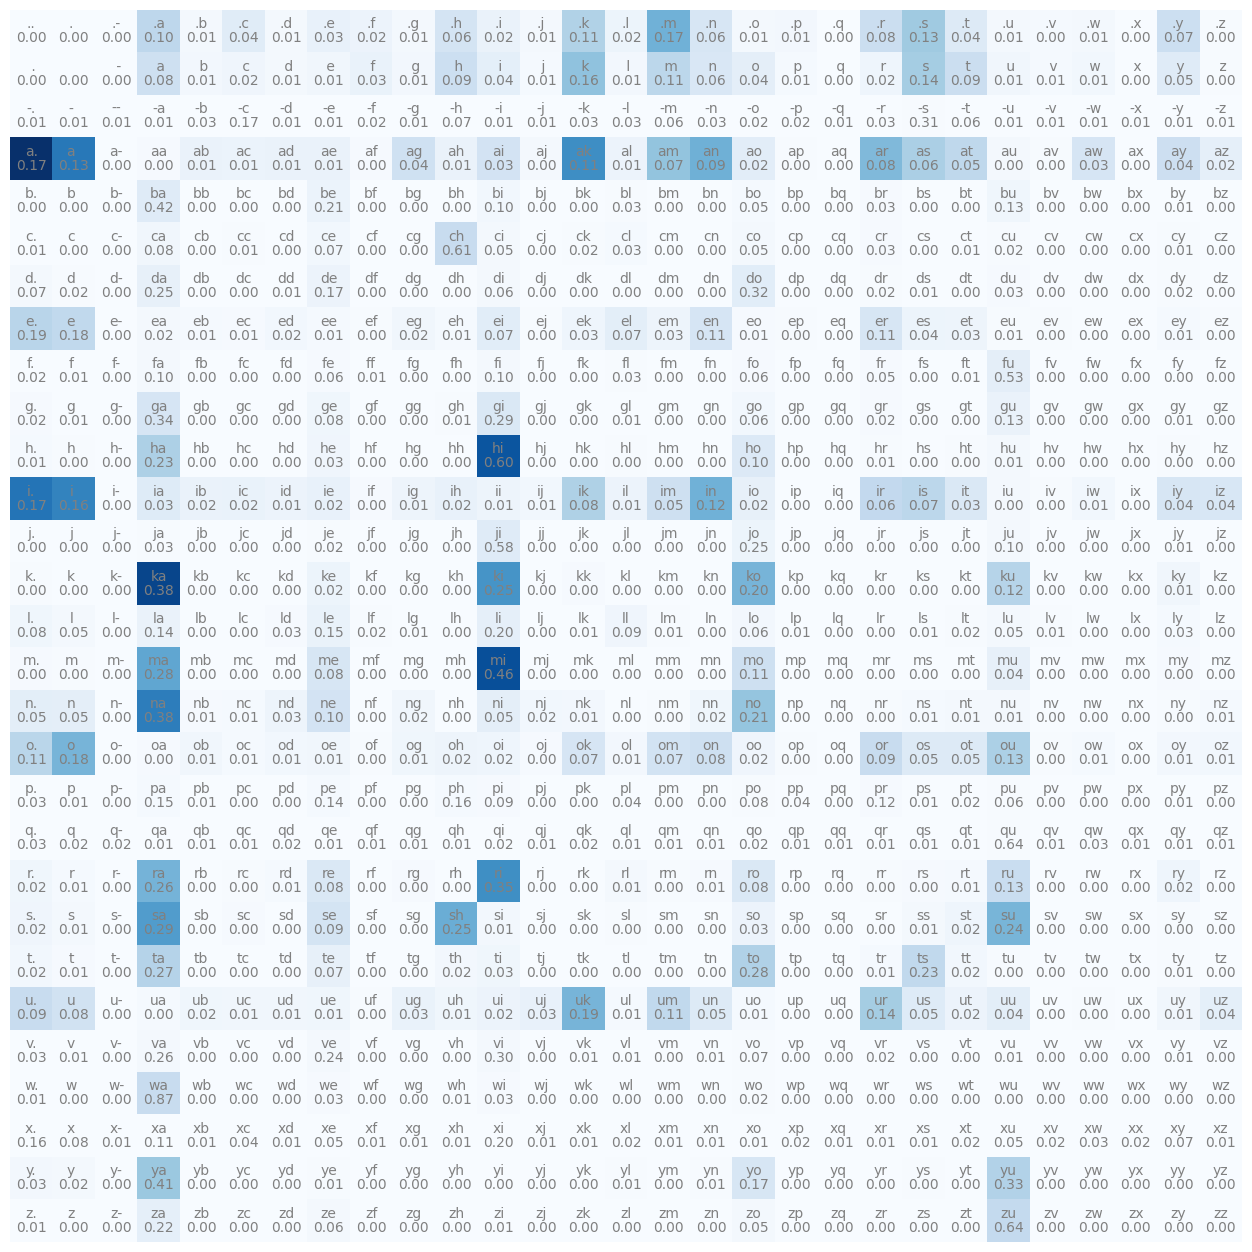

In [14]:
plt.figure(figsize=(16,16))
plt.imshow(N, cmap="Blues")
for i in range(len(chars)):
    for j in range(len(chars)):
        chstr = idx_to_char[i] + idx_to_char[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color='gray')
        plt.text(j, i, f"{P[i, j].item():.2f}", ha="center", va="top", color='gray')
plt.axis('off')

## Sampling from Model

In [18]:
# sampling
g = torch.Generator().manual_seed(16)
for _ in range(10):
    samples = ["."]
    while True:
        last_sample = samples[-1]
        last_sample_idx = char_to_idx[last_sample]
        relevant_probs = P[last_sample_idx]
        uniform_probs = torch.ones(len(chars)) / len(chars) # for baseline testing
        
        sampled_idx = torch.multinomial(relevant_probs, 1, True, generator=g).data.item()
        sampled_char = idx_to_char[sampled_idx]
        samples.append(sampled_char)
        
        if sampled_char == end_token:
            break

    print("".join(samples))

.choyaki n clvifukanerakazustora ku.
.ena.
.hi.
.tokistouitorasakine.
.hiarawakosu.
.rugo ki obagikaminnchire kayujosaka.
.yusaba.
.ko.
.nanakoya minorindou.
.semiriledra.


## Evaluating Model

In [19]:
# evaluating this bigram model
# maximum likelihood
# likelihood: multiply together probabilities

log_probs = []
for word in words:
    word = start_token + word + end_token
    for (c1, c2) in zip(word, word[1:]):
        idx1 = char_to_idx[c1]
        idx2 = char_to_idx[c2]
        
        prob = P[idx1, idx2]
        log_prob = prob.log()
        # print(prob, lo)
        log_probs.append(log_prob)
        
        # print(f"{c1}{c2}: {prob:.4f} {log_prob:.4f}")

log_likelihood = torch.tensor(log_probs).sum()
nlog_likelihood = log_likelihood * -1

print(f"{log_likelihood=}")
print(f"{nlog_likelihood=}")
print(nlog_likelihood / len(log_probs))
        

log_likelihood=tensor(-830999.7500)
nlog_likelihood=tensor(830999.7500)
tensor(2.2352)


## Gradient Approach

In [20]:
# doing the same, but now workign with torch tensors instead of other intermediary shit
xs = []
ys = []
for word in words:
    word = start_token + word + end_token
    for (c1, c2) in zip(word, word[1:]):
        idx1 = char_to_idx[c1]; idx2 = char_to_idx[c2]
        xs.append(idx1)
        ys.append(idx2)
        
xs = torch.tensor(xs)
ys = torch.tensor(ys)
print(xs.shape, ys.shape)

xenc: torch.Tensor = F.one_hot(xs, num_classes=len(chars)).float()
print(xenc.shape)

torch.Size([371786]) torch.Size([371786])
torch.Size([371786, 29])


In [21]:
# model initialization
g = torch.Generator().manual_seed(16)
W = torch.randn((len(chars), len(chars)), requires_grad=True, generator=g)

In [25]:
for iteration in range(100):
    # forward pass
    logits = xenc @ W # interpreting as log(counts) [logits] [negative & positive range]
    counts = logits.exp() # counts
    probs = counts / counts.sum(dim=1, keepdim=True) # prob distribs
    loss = -probs[torch.arange(len(ys)), ys].log().mean()
    loss
    
    print(f"{iteration:03d}: {loss=}")

    # backward pass
    W.grad = None # flushing gradients
    loss.backward()

    # update
    W.data += -50 * W.grad
    # W.data += -10 * W.grad

000: loss=tensor(2.2446, grad_fn=<NegBackward0>)
001: loss=tensor(2.2446, grad_fn=<NegBackward0>)
002: loss=tensor(2.2445, grad_fn=<NegBackward0>)
003: loss=tensor(2.2445, grad_fn=<NegBackward0>)
004: loss=tensor(2.2444, grad_fn=<NegBackward0>)
005: loss=tensor(2.2444, grad_fn=<NegBackward0>)
006: loss=tensor(2.2443, grad_fn=<NegBackward0>)
007: loss=tensor(2.2443, grad_fn=<NegBackward0>)
008: loss=tensor(2.2442, grad_fn=<NegBackward0>)
009: loss=tensor(2.2442, grad_fn=<NegBackward0>)
010: loss=tensor(2.2442, grad_fn=<NegBackward0>)
011: loss=tensor(2.2441, grad_fn=<NegBackward0>)
012: loss=tensor(2.2441, grad_fn=<NegBackward0>)
013: loss=tensor(2.2440, grad_fn=<NegBackward0>)
014: loss=tensor(2.2440, grad_fn=<NegBackward0>)
015: loss=tensor(2.2439, grad_fn=<NegBackward0>)
016: loss=tensor(2.2439, grad_fn=<NegBackward0>)
017: loss=tensor(2.2439, grad_fn=<NegBackward0>)
018: loss=tensor(2.2438, grad_fn=<NegBackward0>)
019: loss=tensor(2.2438, grad_fn=<NegBackward0>)
020: loss=tensor(2.2

In [26]:
# all xenc is doing is plucking out rows
counts = W.exp()
probs = counts / counts.sum(dim=1, keepdim=True)
probs

tensor([[6.3801e-04, 6.0630e-04, 6.9506e-04, 9.5694e-02, 6.7460e-03, 3.9608e-02,
         5.5281e-03, 2.6140e-02, 1.9477e-02, 5.8510e-03, 6.1276e-02, 2.2451e-02,
         6.9648e-03, 1.0834e-01, 1.8510e-02, 1.6858e-01, 5.5474e-02, 7.2512e-03,
         8.5793e-03, 1.2071e-03, 7.5638e-02, 1.2732e-01, 4.4157e-02, 6.6410e-03,
         4.1283e-03, 5.2757e-03, 8.1286e-04, 7.4814e-02, 1.6033e-03],
        [7.8771e-04, 8.9237e-04, 7.7250e-04, 8.1664e-02, 9.5012e-03, 1.5559e-02,
         7.5334e-03, 1.2818e-02, 2.7131e-02, 9.9518e-03, 8.5016e-02, 3.6780e-02,
         5.5271e-03, 1.6096e-01, 1.0238e-02, 1.0934e-01, 5.8732e-02, 3.7025e-02,
         5.6458e-03, 8.7046e-04, 1.8177e-02, 1.3967e-01, 8.6283e-02, 1.2695e-02,
         5.6884e-03, 1.1713e-02, 6.3707e-04, 4.6673e-02, 1.7198e-03],
        [2.6131e-02, 2.2271e-02, 2.2203e-02, 1.6774e-02, 1.8155e-02, 6.6576e-02,
         2.3615e-02, 2.1505e-02, 1.2167e-02, 1.3656e-02, 1.2179e-02, 8.7006e-02,
         7.7424e-02, 2.2365e-02, 7.0769e-02, 9.352

(-0.5, 28.5, 28.5, -0.5)

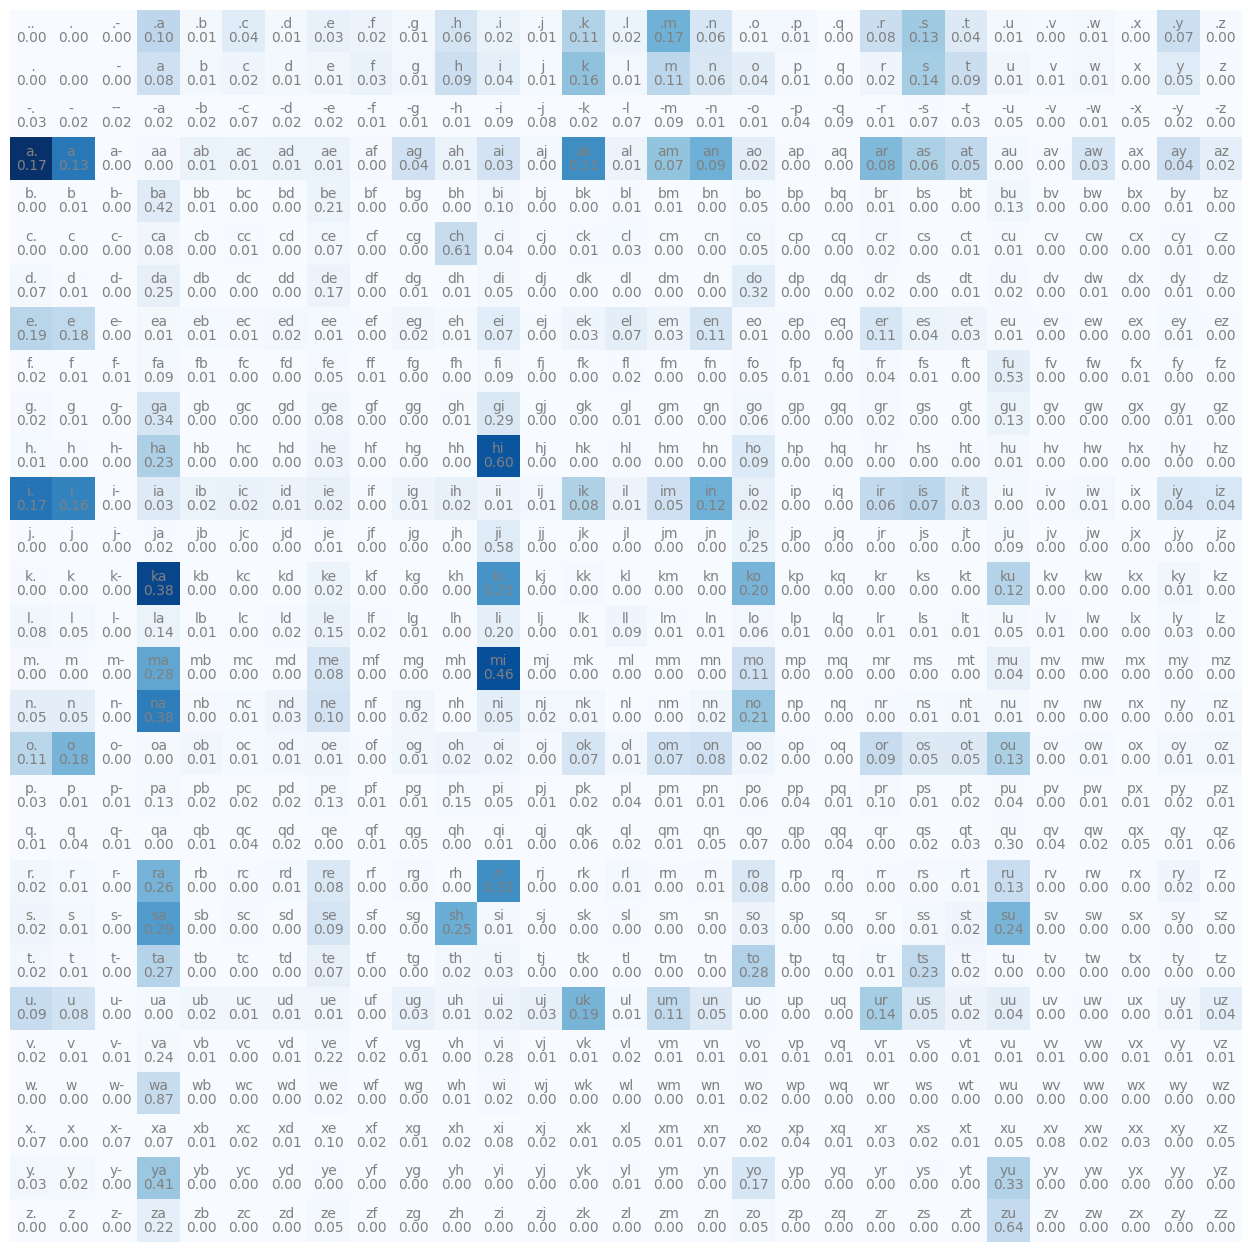

In [27]:
plt.figure(figsize=(16,16))
plt.imshow(N, cmap='Blues')
for i in range(len(chars)):
    for j in range(len(chars)):
        chstr = idx_to_char[i] + idx_to_char[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color='gray')
        plt.text(j, i, f"{probs[i, j].item():.2f}", ha="center", va="top", color='gray')
plt.axis('off')